# WM-811K Dataset Cleaning, Splitting, and Dummy Wafer Augmentations

This notebook is a walkthrough of (mostly) everything data-related for our project. The first major portion of this notebook details our data acquisition, cleaning, and splitting methods. In the second half, we prototype custom image augmentations for wafer maps and ensure that our dummy examples can integrate with `lightly`.

## Part 1: Everything Data

### Imports

In [5]:
import os
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from IPython.display import display
from lightly.data.collate import MultiViewCollateFunction
from lightly.transforms.rotation import RandomRotate
from lightly.utils.debug import plot_augmented_images
from PIL import Image
from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split
from torch import nn
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm

### Exploratory Data Analysis

In this section, we download the WM-811K dataset, visualize the distribution of labeled categories, and clean the data.

In [3]:
# Create directory for data
os.makedirs("../data/", exist_ok=True)

# Download zip file from online, and extract everything to data/
url = "http://mirlab.org/dataset/public/MIR-WM811K.zip"
# Proceeed only if data hasn't been downloaded already:
if not os.path.isdir("../data/MIR-WM811K"):
    with urlopen(url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall("../data/")
else:
    print("Found wafer data already")

Found wafer data already


In [4]:
path = "../data/MIR-WM811K/Python/WM811K.pkl"
df = pd.read_pickle(path)
df

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
811452,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811453,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."
811454,600.0,Edge-Ring,lot47542,Test,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811455,600.0,"[0, 0]",lot47543,"[0, 0]",1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."


In [6]:
# [0, 0] is unhashable in failureType and trainTestLabel --> replace with "unlabeled"
array_mask = df.failureType.apply(pd.api.types.is_array_like)
failure_labels = df.failureType.copy()
traintest_labels = df.trainTestLabel.copy()

failure_labels[array_mask] = "unlabeled"
traintest_labels[array_mask] = "unlabeled"

df.failureType = failure_labels
df.trainTestLabel = traintest_labels
df

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
811452,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811453,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."
811454,600.0,Edge-Ring,lot47542,Test,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811455,600.0,unlabeled,lot47543,unlabeled,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."


The distribution of failure type categories is heavily skewed. Moreover, the distributions of the `"Training"` and `"Test"` datasets isn't even the same! Both datasets have far more "none"-type failure shadings than the other types (which is typical of qualified semiconductor products going through high-volume manufacturing). However, the `"Test"` dataset's "none"-type shadings dwarfs the other failure shadings entirely.

,count,fraction
none,36730,0.675743
Edge-Ring,8554,0.157373
Center,3462,0.063692
Edge-Loc,2417,0.044467
Loc,1620,0.029804
Random,609,0.011204
Scratch,500,0.009199
Donut,409,0.007525
Near-full,54,0.000993


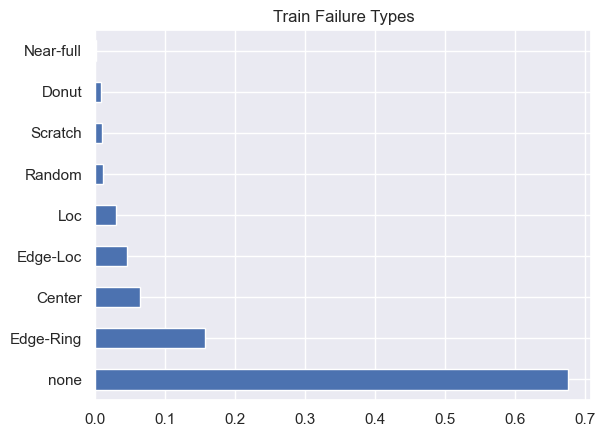

,count,fraction
none,110701,0.933437
Edge-Loc,2772,0.023374
Loc,1973,0.016636
Edge-Ring,1126,0.009494
Center,832,0.007015
Scratch,693,0.005843
Random,257,0.002167
Donut,146,0.001231
Near-full,95,0.000801


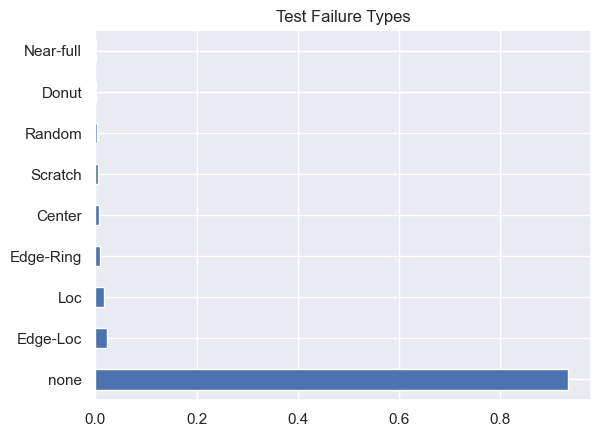

In [7]:
sns.set_theme()

def show_breakdown(series, title=None):
    """
    Given a pandas Series, displays value_counts(), both raw counts and normalized.
    Also plots a horizontal bar chart of normalized value counts.
    """
    breakdown = pd.concat(
        [series.value_counts(), series.value_counts(normalize=True)],
        axis=1,
        keys=("count", "fraction")
    )
    display(breakdown)
    breakdown.fraction.plot(kind="barh")
    if title:
        plt.title(title)
    plt.show()


train_shadings = df.loc[df.trainTestLabel == "Training"].failureType
test_shadings = df.loc[df.trainTestLabel == "Test"].failureType

show_breakdown(train_shadings, title="Train Failure Types")
show_breakdown(test_shadings, title="Test Failure Types")

We've come across papers that choose to ignore this `"Test"` dataset entirely and create custom training and test datasets from the `"Training"` subset alone. This is usually done to ensure that the data can be split in a stratified fashion. We follow a similar approach here, but rather than throwing out the `"Test"` dataset entirely, we keep all non-"none"-type failure shadings from that datasets. Concretely, we create an aggregate dataset that has all of the `"Training"` subset, and everything in `"Test"` where `failureType != "none"`.

In [8]:
# Get rid of everything unlabeled, then we want everything that isn't a Test + none-failureType
idx = (df.trainTestLabel == "unlabeled") | (
    (df.trainTestLabel == "Test") & (df.failureType == "none")
)
data = df.loc[~idx].reset_index(drop=True)

# Create new columns that tells me whether a wafermap is square already
data["isSquare"] = df.waferMap.apply(lambda m: all(len(row) == len(m) for row in m))
data["shapeMaxDim"] = df.waferMap.apply(lambda x: max(x.shape))
data

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap,isSquare,shapeMaxDim
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
...,...,...,...,...,...,...,...,...
62244,600.0,Edge-Loc,lot47542,Test,21.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",False,34
62245,600.0,Edge-Loc,lot47542,Test,22.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",False,34
62246,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",False,34
62247,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",False,34


Because I've worked with this data once before, I know that there's a single data point here that is not a real wafermap (it's probably just a slice of one). Its waferMap is just 3 columns long, and not even close to a square.

In [9]:
bad_idx = data.waferMap.apply(lambda x: np.size(x)).argmin()
print(bad_idx)
data.waferMap.iloc[bad_idx]

46155


array([[0, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [10]:
# Drop the bad row and reset the indices
data.drop(index=bad_idx, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap,isSquare,shapeMaxDim
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False,48
...,...,...,...,...,...,...,...,...
62243,600.0,Edge-Loc,lot47542,Test,21.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",False,34
62244,600.0,Edge-Loc,lot47542,Test,22.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",False,34
62245,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",False,34
62246,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",False,34


With this cleaned and aggregated data, we can create our own train and test splits, stratifying them according to the failure types. Below, we split the aggregate data into an 80/20 train/test split, and we verify that the distributions of failure categories across our splits are the same thanks to stratified splitting.

,count,fraction
none,29383,0.590044
Edge-Ring,7744,0.155508
Edge-Loc,4151,0.083357
Center,3435,0.068979
Loc,2874,0.057713
Scratch,955,0.019177
Random,693,0.013916
Donut,444,0.008916
Near-full,119,0.002390


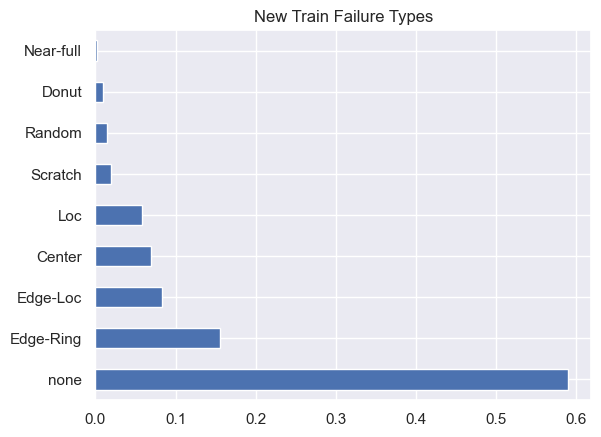

,count,fraction
none,7346,0.590040
Edge-Ring,1936,0.155502
Edge-Loc,1038,0.083373
Center,859,0.068996
Loc,719,0.057751
Scratch,238,0.019116
Random,173,0.013896
Donut,111,0.008916
Near-full,30,0.002410


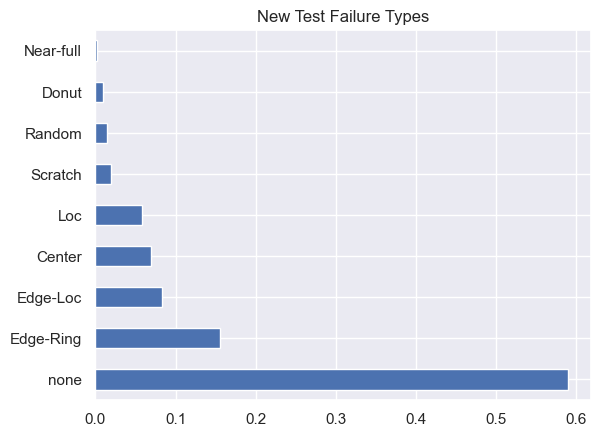

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data.waferMap,
    data.failureType,
    test_size=0.2,
    stratify=data.failureType,  # stratified split!
    random_state=0,
)
show_breakdown(y_train, title="New Train Failure Types")
show_breakdown(y_test, title="New Test Failure Types")

For compatibility with image processing libraries, the domain of our NumPy arrays will need to be scaled to an RGB domain.

In [12]:
# Modified from https://github.com/sparks-baird/xtal2png/blob/main/src/xtal2png/utils/data.py#L138
def rgb_scale(
    X, feature_range=[0, 255], data_range=None,
):
    """Scales array to RGB domain [0, 255]
    """
    import numpy as np
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    if data_range is None:
        data_range = [np.min(X), np.max(X)]
    if feature_range is None:
        feature_range = [np.min(X), np.max(X)]

    data_min, data_max = data_range
    feature_min, feature_max = feature_range
    X_std = (X - data_min) / (data_max - data_min)
    X_scaled = X_std * (feature_max - feature_min) + feature_min
    X_scaled = np.round(X_scaled).astype(np.uint8)
    return X_scaled

In [13]:
from pandarallel import pandarallel  # for parallel processing of df.apply, df.applymap

pandarallel.initialize(progress_bar=True)

X_train = X_train.parallel_apply(rgb_scale)
X_test = X_test.parallel_apply(rgb_scale)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Additionally, we'll want to have a column with category codes (integers) instead of just the failure types (strings)

In [14]:
# Create a column of category codes for failureType
y_train_codes = y_train.astype("category").cat.codes
y_test_codes = y_test.astype("category").cat.codes
y_train_codes.name = y_test_codes.name = "failureCode"

train_data = pd.concat([X_train, y_train, y_train_codes], axis="columns")
test_data = pd.concat([X_test, y_test, y_test_codes], axis="columns")

display(train_data)
display(test_data)

,waferMap,failureType,failureCode
43809,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255...",none,8
14410,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8
2428,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128, 128,...",none,8
50938,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128, 128,...",none,8
45657,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3
...,...,...,...
775,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...",none,8
12564,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, ...",Edge-Ring,3
36239,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...",none,8
15061,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3


,waferMap,failureType,failureCode
40277,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...",none,8
16953,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...",none,8
20406,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Donut,1
6103,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 128,...",none,8
13716,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3
...,...,...,...
33448,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128...",none,8
5111,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128, 128,...",none,8
37139,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...",none,8
14678,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8


Now, we'll create further splits of our data for the purpose of fine-tuning and comparing against fully supervised baselines. These splits will come from the training dataset. Recall we created an 80/20 split for `train_data` and `test_data`. This `train_data` will be broken down into a validation set and multiple subsets for finetuning: one with 1\% of the training labels, another 10\%, another with 20\%, and the last will have the 29\% leftover. First, we create the `val_data` and initial `train_split` below:

In [16]:
# Make val_data 20% of the full dataset like test_data by doing 0.25 * 80%
train_split, val_data = train_test_split(
    train_data, test_size=0.25, stratify=train_data.failureType, random_state=0
)
# train_split is now 0.75 * 80 = 60% of original dataset (60% of all labels)
display(train_split)
display(val_data)

,waferMap,failureType,failureCode
53885,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128, 128,...",none,8
41170,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...",none,8
32829,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...",none,8
52860,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128, 128,...",none,8
13414,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3
...,...,...,...
55641,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...",Loc,4
51722,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128, 128,...",none,8
58887,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12...",none,8
37900,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128...",none,8


,waferMap,failureType,failureCode
23933,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, ...",Edge-Ring,3
27571,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...",Edge-Loc,2
54216,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...",none,8
6419,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8
6697,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8
...,...,...,...
57145,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4
56854,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8
19726,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3
45974,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...",none,8


Now we use the `train_split` to create further splits for finetuning. Below this, we've included an icicle plot that visualizes the splits and their parent splits from the data to make things a bit more intuitive.

In [63]:
# Grab a 1% split from the 60% remaining data
train_59_split, train_1_split = train_test_split(
    train_split, test_size=1 / 60, stratify=train_split.failureType, random_state=0
)
# Grab a 10% split from the 59% remaining data
train_49_split, train_10_split = train_test_split(
    train_59_split,
    test_size=10 / 59,
    stratify=train_59_split.failureType,
    random_state=0,
)
# Grab a 20% split from the 49% remaining data
train_29_split, train_20_split = train_test_split(
    train_49_split,
    test_size=20 / 49,
    stratify=train_49_split.failureType,
    random_state=0,
)
# Sanity checks for lengths of all these splits
print(f"0.01 split {len(train_1_split) / (len(data)):.5f}")
print(f"0.10 split {len(train_10_split) / (len(data)):.5f}")
print(f"0.20 split {len(train_20_split) / (len(data)):.5f}")
print(f"0.29 split {len(train_29_split) / (len(data)):.5f}")
print(f"0.49 split {len(train_49_split) / (len(data)):.5f}")
print(f"0.59 split {len(train_59_split) / (len(data)):.5f}\n")
print(f"full train data {len(train_data) / (len(data)):.5f}")
print(f"val data {len(val_data) / (len(data)):.5f}")
print(f"test data {len(test_data) / (len(data)):.5f}")

0.01 split 0.01001
0.10 split 0.10000
0.20 split 0.19999
0.29 split 0.28999
0.49 split 0.48998
0.59 split 0.58998

full train data 0.79999
val data 0.20001
test data 0.20001


In [66]:
import plotly.graph_objects as go

# Make an icicle plot for our paper showing breakdown of data
fig = go.Figure(
    go.Icicle(
        labels=[
            "Full Data (100)",
            "Full Train Data (80)",
            "Test Data (20)",
            "Val Data (20)",
            "Rest of Train Split (60)",
            "1% Train Finetune",
            "Remaining (59)",
            "10% Train Finetune",
            "Remaining (49)",
            "20% Train Finetune",
            "29% Train Finetune",
        ],
        parents=[
            "",
            "Full Data (100)",
            "Full Data (100)",
            "Full Train Data (80)",
            "Full Train Data (80)",
            "Rest of Train Split (60)",
            "Rest of Train Split (60)",
            "Remaining (59)",
            "Remaining (59)",
            "Remaining (49)",
            "Remaining (49)",
        ],
        values = [
            len(data),
            len(train_data),
            len(test_data),
            len(val_data),
            len(train_split),
            len(train_1_split),
            len(train_59_split),
            len(train_10_split),
            len(train_49_split),
            len(train_20_split),
            len(train_29_split)
        ],
        branchvalues="total",
        root_color="lightgrey"
    )
)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

Note that because we've done stratified splits, the breakdowns of failure categories in each split is ***the same***! As a sanity check, we show that the distributions of categories are exactly the same across all our new splits `train_1_split`, `train_10_split`, `train_20_split`, `train_29_split`, and `val_data`

623


,count,fraction
none,368,0.590690
Edge-Ring,97,0.155698
Edge-Loc,52,0.083467
Center,43,0.069021
Loc,36,0.057785
Scratch,12,0.019262
Random,9,0.014446
Donut,5,0.008026
Near-full,1,0.001605


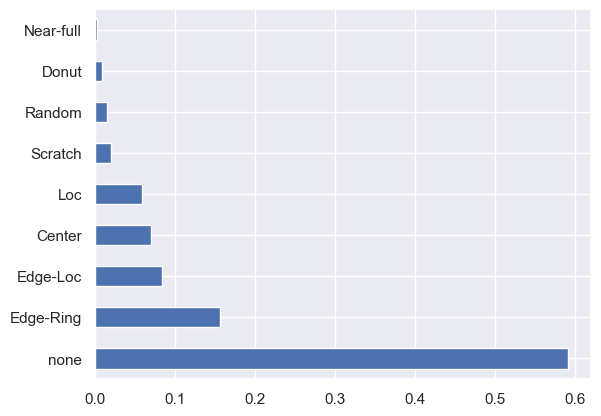

6225


,count,fraction
none,3673,0.590040
Edge-Ring,968,0.155502
Edge-Loc,519,0.083373
Center,429,0.068916
Loc,359,0.057671
Scratch,119,0.019116
Random,87,0.013976
Donut,56,0.008996
Near-full,15,0.002410


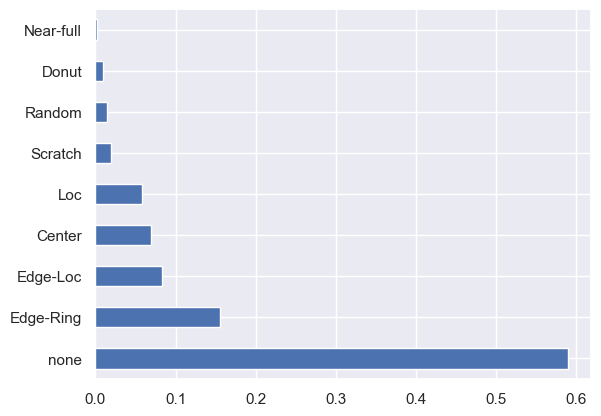

12449


,count,fraction
none,7345,0.590007
Edge-Ring,1936,0.155514
Edge-Loc,1037,0.083300
Center,859,0.069002
Loc,719,0.057756
Scratch,239,0.019198
Random,173,0.013897
Donut,111,0.008916
Near-full,30,0.002410


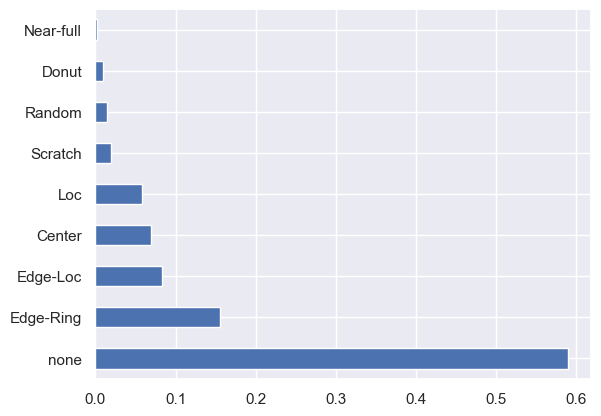

18051


,count,fraction
none,10651,0.590050
Edge-Ring,2807,0.155504
Edge-Loc,1505,0.083375
Center,1245,0.068971
Loc,1042,0.057725
Scratch,346,0.019168
Random,251,0.013905
Donut,161,0.008919
Near-full,43,0.002382


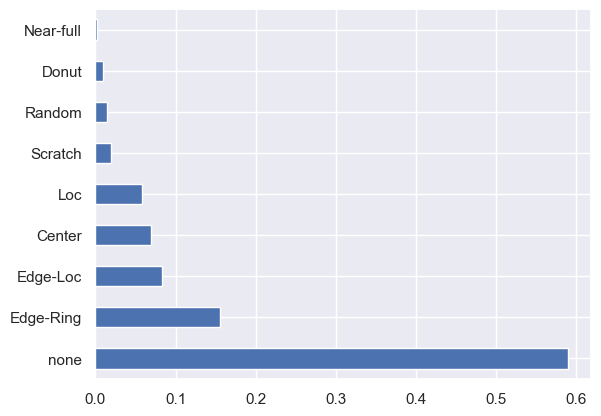

12450


,count,fraction
none,7346,0.590040
Edge-Ring,1936,0.155502
Edge-Loc,1038,0.083373
Center,859,0.068996
Loc,718,0.057671
Scratch,239,0.019197
Random,173,0.013896
Donut,111,0.008916
Near-full,30,0.002410


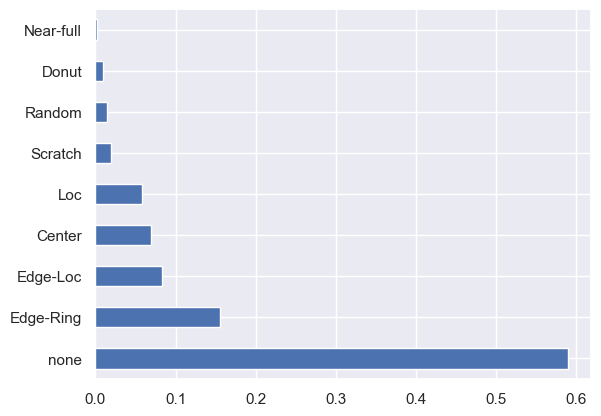

In [65]:
for series in (train_1_split, train_10_split, train_20_split, train_29_split, val_data):
    print(len(series))
    show_breakdown(series.failureType)

In [67]:
# save all splits from full training data to file
save_path = "../data/cleaned_splits"
os.makedirs(save_path, exist_ok=True)
train_data.to_pickle(f"{save_path}/train_data.pkl")
test_data.to_pickle(f"{save_path}/test_data.pkl")
val_data.to_pickle(f"{save_path}/val_data.pkl")
train_split.to_pickle(f"{save_path}/train_split.pkl")
train_1_split.to_pickle(f"{save_path}/train_1_split.pkl")
train_10_split.to_pickle(f"{save_path}/train_10_split.pkl")
train_20_split.to_pickle(f"{save_path}/train_20_split.pkl")
train_29_split.to_pickle(f"{save_path}/train_29_split.pkl")

## Part 2: Image Processing of Wafer Maps

### Dummy Image Augmentations with NumPy Arrays

Let's load a wafer for the purpose of debugging image augmentations.

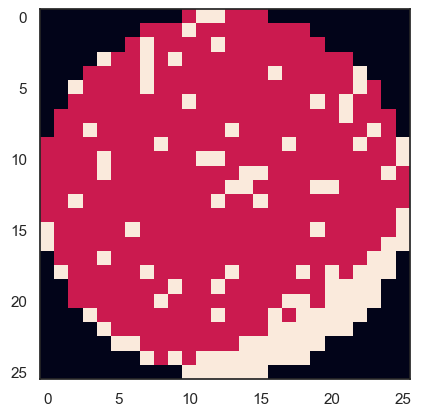

In [12]:
sns.set_theme(style="white", palette=None)

wafer = (
    data.loc[
        (data.failureType != "none")
        & (data.isSquare == True)
        & (data.shapeMaxDim < 50)
    ]
    .iloc[59]
    .waferMap
)
# wafer = (
#     data.loc[
#         (data.failureType != "none")
#         & (data.isSquare == False)
#         & (data.shapeMaxDim > 128)
#     ]
#     .iloc[42]
#     .waferMap
# )
plt.imshow(wafer);

Below, we test all of torchvision's interpolation modes to see which are valid for wafer maps. A valid wafer map, even when resized, should have a discrete domain for non-wafer area, passing die, and failing die. If `np.unique(resized_wafer).size != 3`, then the interpolation mode is invalid.

nearest valid


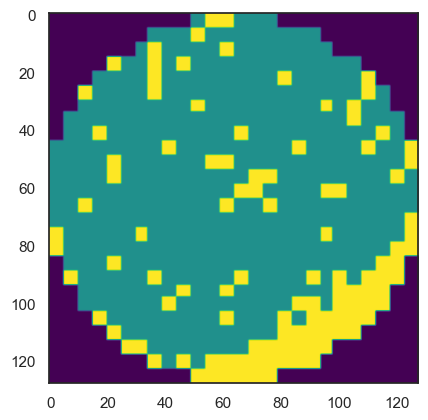

bilinear NOT VALID
bicubic NOT VALID
box valid


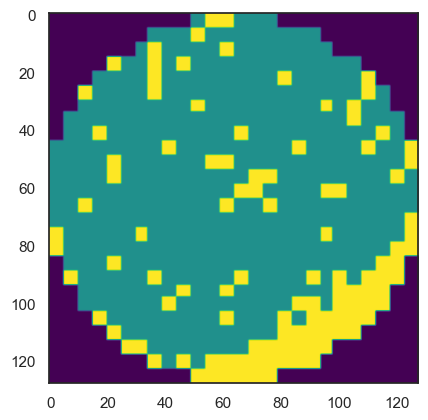

hamming NOT VALID
lanczos NOT VALID


In [13]:
sns.set_theme(style="white", palette=None)

modes = {
    "nearest": InterpolationMode.NEAREST,
    "bilinear": InterpolationMode.BILINEAR,
    "bicubic": InterpolationMode.BICUBIC,
    "box": InterpolationMode.BOX,
    "hamming": InterpolationMode.HAMMING,
    "lanczos": InterpolationMode.LANCZOS
}

for name, mode in modes.items():
    resize = T.Resize([128, 128], interpolation=mode)
    rs_wafer = resize(Image.fromarray(rgb_scale(wafer)))

    if (np.unique(np.array(rs_wafer)).size) != 3:
        print(f"{name} NOT VALID")
    else:
        print(f"{name} valid")
        plt.imshow(rs_wafer, cmap="viridis")
        plt.show()

Only the `NEAREST` and `BOX` interpoloation modes are unique. Now let's create a dummy example for our flip function. For every die (that is, everything in the image that isn't non-wafer area), we have some probability of flipping the die from pass to fail and vice-versa.

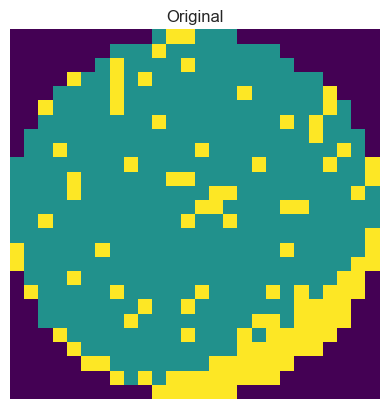

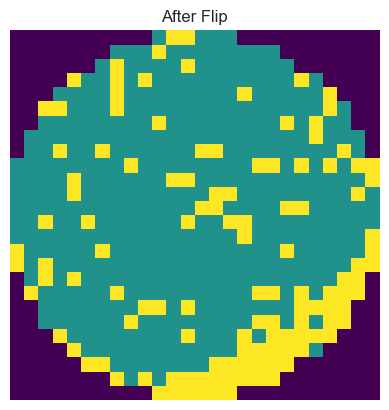

In [14]:
def flip(item, p=0.03):
    """
    Given a wafermap die, flips pass to fail and vice-versa with probability p.
    Does nothing to non-die area (0's if 1's and 2's are passes/fails respectively).
    """
    prob = np.random.choice([False, True], p=[1 - p, p])
    if prob:
        if item == 1:
            return 2
        elif item == 2:
            return 1
        else:
            return item
    return item


# Vectorize flip function to apply it to every element in array
vflip = np.vectorize(flip)

sns.heatmap(
    wafer,
    # annot=True,
    cmap="viridis",
    cbar=False,
    square=True,
    yticklabels=False,
    xticklabels=False,
)
plt.title("Original")
plt.show()

sns.heatmap(
    vflip(wafer.copy()),
    # annot=True,
    cmap="viridis",
    cbar=False,
    square=True,
    yticklabels=False,
    xticklabels=False,
)
plt.title("After Flip")
plt.show()

Let's string together a bunch of augmentations, still applying them to NumPy arrays for now.
1. First, apply random die noise using `vflip` function. Must be done before any resizing or rescaling since this expects 0's, 1's, and 2's
2. Scale data to RGB range: $[0, 1, 2] \rightarrow [0, 128, 255]$
3. Convert array/tensor to PIL `Image` for further torchvision transforms
4. Resize to $128 \times 128$
5. 50\% chance of rotating image by 90 degrees
6. 50\% chance of vertically flipping image
7. 50\% chance of horizontally flipping image
8. 25\% chance of randomly rotating the image, this time somewhere between 0 to 90 degrees.
9. Finally, convert the single channel image to 3-channel by repeating the first channel for all three R, G, B channels.

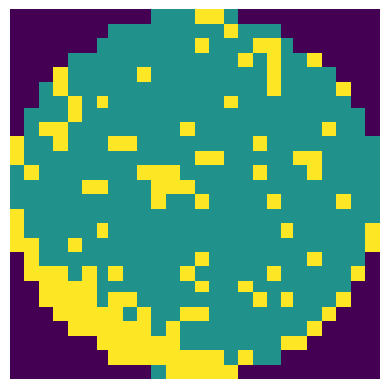

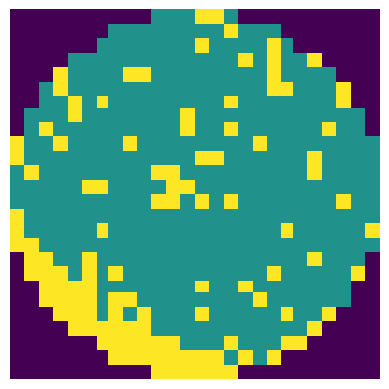

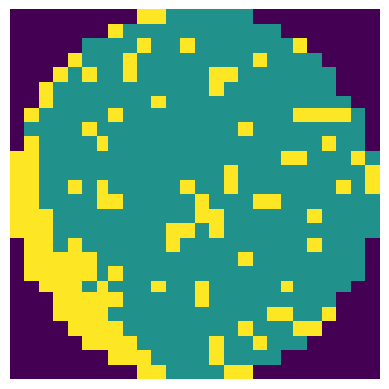

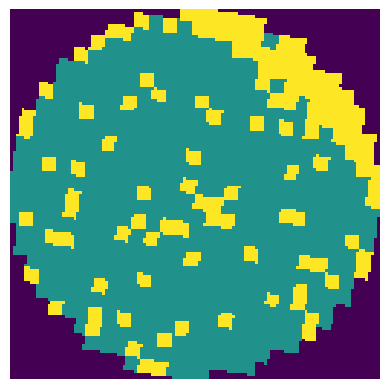

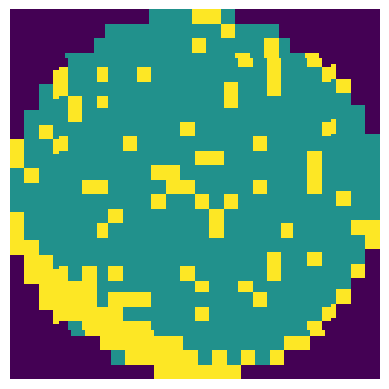

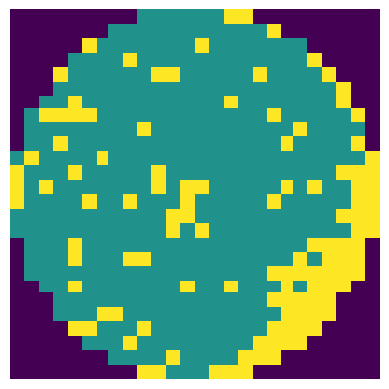

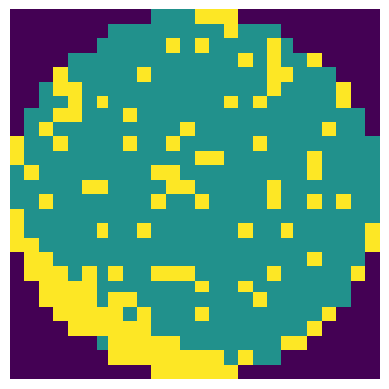

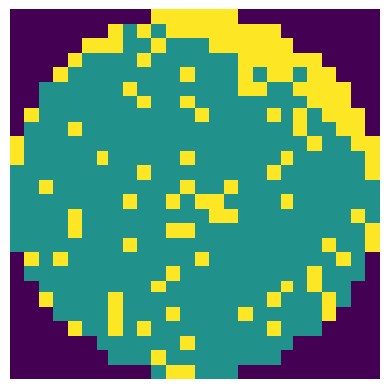

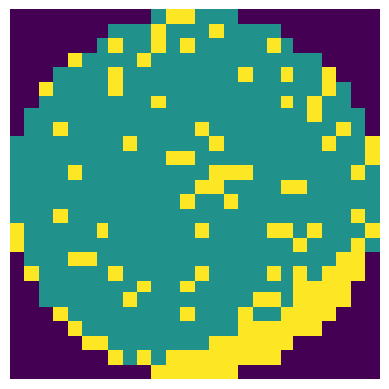

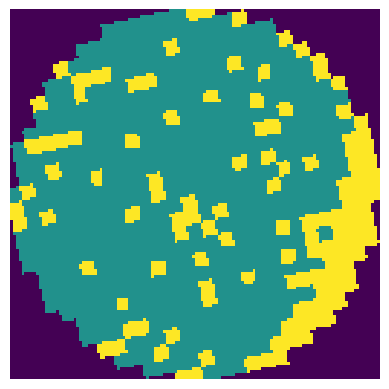

In [15]:
sns.set_theme(style="white", palette=None)

aug = T.Compose([
    T.Lambda(lambda x: vflip(x.copy())),
    T.Lambda(lambda x: rgb_scale(x)),
    # T.Lambda(lambda x: torch.from_numpy(wafer).unsqueeze(dim=0)),  # Must be used if RandomErasing
    # T.RandomErasing(p=0.25, scale=(0.13, 0.13), ratio=(0.7, 1.3), value=0, inplace=False),  # Must come before ToPILImage
    T.ToPILImage(),
    T.Resize([128, 128], interpolation=InterpolationMode.NEAREST),
    RandomRotate(),
    T.RandomVerticalFlip(),
    T.RandomHorizontalFlip(),
    T.RandomApply(
        torch.nn.ModuleList(
            [T.RandomRotation(90, interpolation=InterpolationMode.NEAREST)]
        ), 
        0.25
    ),
    T.Grayscale(num_output_channels=3),  # R == G == B
])

# 10 augmentation compositions
for _ in range(10):
    aug_wafer = aug(wafer)
    sns.heatmap(
        # Seaborn doesn't handle 3-channel images, so remove channel dim and plot
        F.pil_to_tensor(aug_wafer)[0, :, :],
        cmap="viridis",
        cbar=False,
        square=True,
        yticklabels=False,
        xticklabels=False,
    )
    plt.show()

In [16]:
TF.pil_to_tensor(rs_wafer)[0, :, :].shape

torch.Size([128, 128])

Finally, we verify that this'll work with a custom collate function in lightly. As described in our FastSiam notebook, our `FastSiamCollateFunction` simply uses a composition of augmentations in conjunction with lightly's `MultiViewCollateFunction`. We use lightly's debugging function `plot_augmented_images()` to show five random samples from the training set (original images), and the 4 augmented images for each one.

<Figure size 640x480 with 0 Axes>

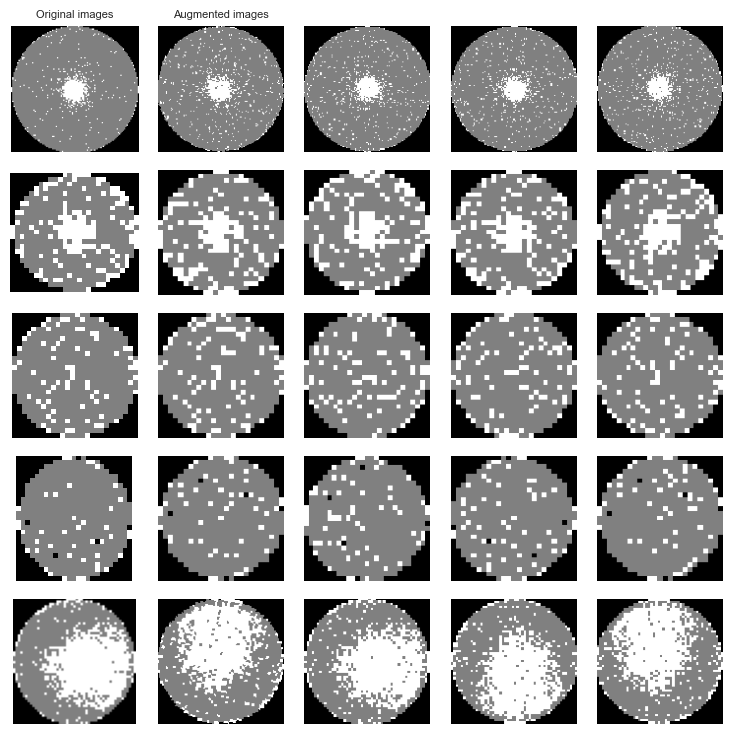

In [17]:
aug = T.Compose([
    T.Lambda(lambda x: vflip(x.copy())),
    T.Lambda(lambda x: rgb_scale(x)),
    T.ToPILImage(),
    T.Resize([128, 128], interpolation=InterpolationMode.NEAREST),
    RandomRotate(),
    T.RandomVerticalFlip(),
    T.RandomHorizontalFlip(),
    T.RandomApply(
        torch.nn.ModuleList(
            [T.RandomRotation(90, interpolation=InterpolationMode.NEAREST)]
        ), 
        0.25
    ),
    T.Grayscale(num_output_channels=3),  # R == G == B
])

FastSiamCollateFunction = MultiViewCollateFunction([aug] * 4)

plt.set_cmap("gray")
plot_augmented_images(
    # Grab 5 random samples from X_train to visualize original and augmented images
    X_train.iloc[np.random.choice(X_train.size, 5)].tolist(),
    FastSiamCollateFunction
);

### Code Graveyard: Trying out rotation but just of the failing die
Problem: can we rotate just the failing die on the wafer, without rotating the original wafer itself? For this, separate wafer background from wafer fails.

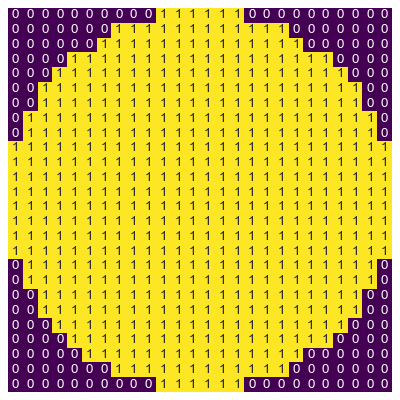

In [646]:
wafer_bg = wafer.copy()
wafer_bg[wafer_bg == 2] = 1
sns.heatmap(
    wafer_bg,
    annot=True,
    cmap="viridis",
    cbar=False,
    square=True,
    yticklabels=False,
    xticklabels=False,
)
plt.show()

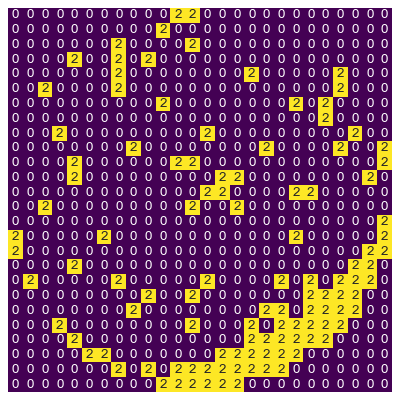

In [651]:
wafer_fails = wafer.copy()
wafer_fails[wafer_fails != 2] = 0
sns.heatmap(
    wafer_fails,
    annot=True,
    cmap="viridis",
    cbar=False,
    square=True,
    yticklabels=False,
    xticklabels=False,
);

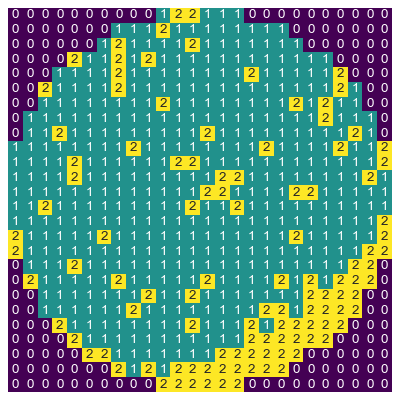

In [652]:
# verify we can get back to original
wafer_or = wafer_fails + wafer_bg
wafer_or[wafer_or == 3] = 2
sns.heatmap(
    wafer_or,
    annot=True,
    cmap="viridis",
    cbar=False,
    square=True,
    yticklabels=False,
    xticklabels=False,
);

Rotate the entire original image. We see that `scipy.ndimage.rotate` doesn't do too great at maintaining image details

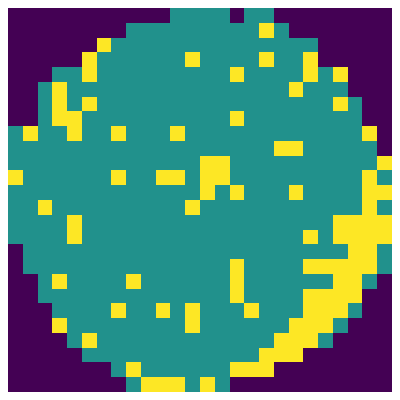

In [690]:
sns.heatmap(
    rotate(wafer.copy(), 27, reshape=False),
    # annot=True,
    cmap="viridis",
    cbar=False,
    square=True,
    yticklabels=False,
    xticklabels=False,
);

Now keep the wafer background fixed, and just add the fails back in

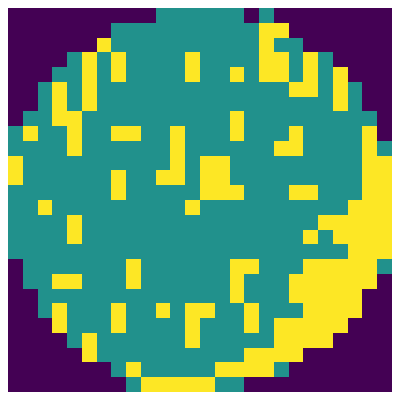

In [697]:
fails_rotate = rotate(wafer_fails, angle=27, reshape=False)
wafer_or = fails_rotate + wafer_bg
wafer_or[wafer_or == 3] = 2
sns.heatmap(
    wafer_or,
    # annot=True,
    cmap="viridis",
    cbar=False,
    square=True,
    yticklabels=False,
    xticklabels=False,
);

We can clearly see that the shading pattern gets destroyed using this method, so we'll stick to simple torchvision transforms.